In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate

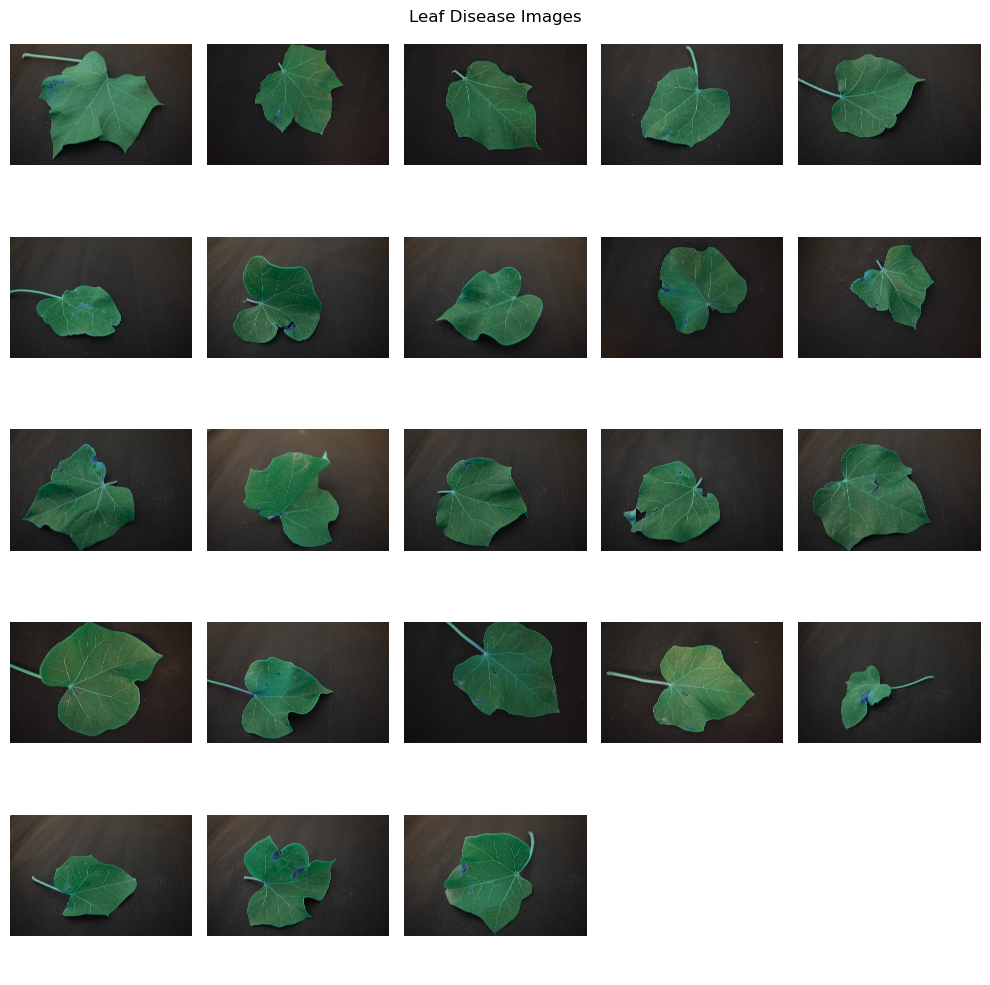

In [2]:
path = "Leaves/"

# Loading Leaf Disease Images
filenames = os.listdir(path)
org_images = []
for name in filenames:
    if name.endswith('.JPG'):
        img_path = os.path.join(path, name)
        img = cv2.imread(img_path, 1)
        org_images.append(img)
# Viewing the loaded images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        index = i * 5 + j
        if index < len(org_images):
            axes[i, j].imshow(org_images[index])
            axes[i, j].axis('off')
        else:
            axes[i, j].axis('off')
plt.tight_layout()
plt.suptitle("Leaf Disease Images")
plt.show()

### Q1) Image Segmentation using Thresholding

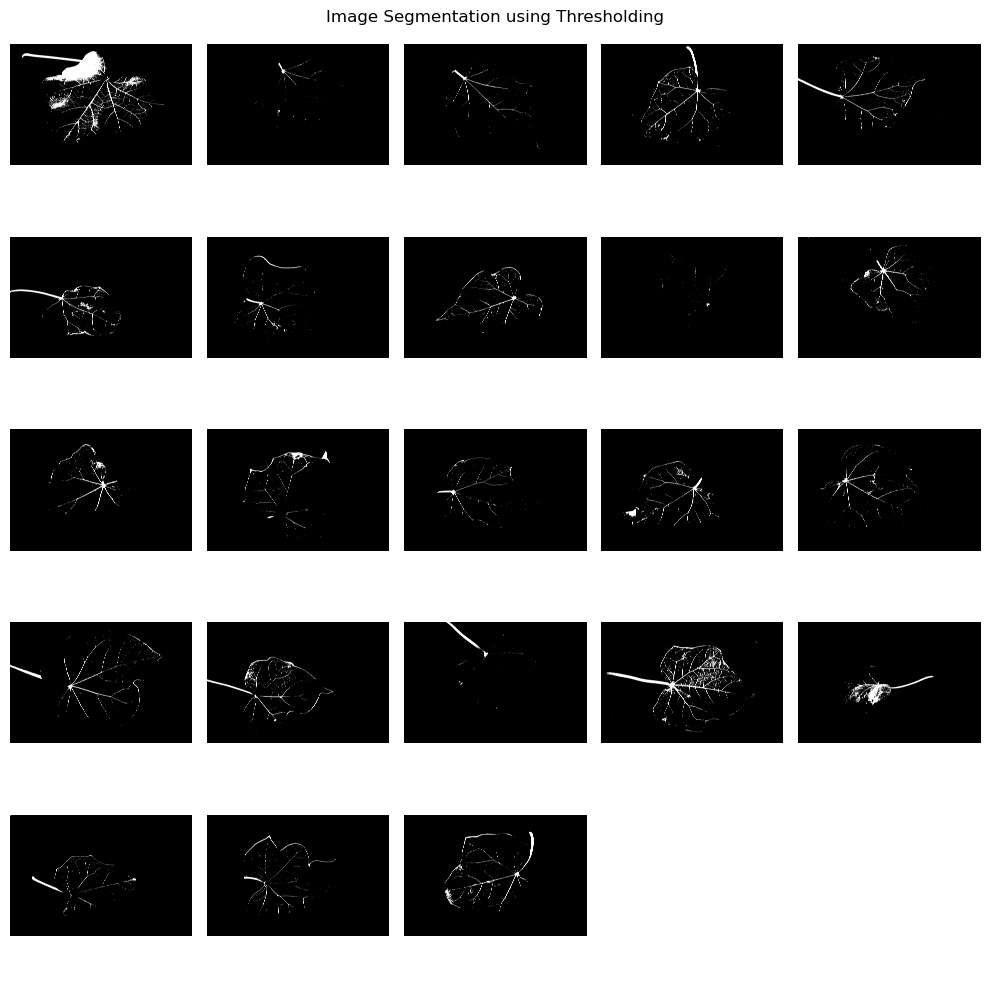

In [3]:
# Define the function to apply threshold
def apply_threshold(image, threshold_value):
    _, thresholded = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    return thresholded

threshold_value = 120
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        index = i * 5 + j
        if index < len(org_images):
            gray_img = cv2.cvtColor(org_images[index], cv2.COLOR_BGR2GRAY)
            segmented_img = apply_threshold(gray_img, threshold_value)
            axes[i, j].imshow(segmented_img, cmap="gray")
            axes[i, j].axis('off')
        else:
            axes[i, j].axis('off')

plt.tight_layout()
plt.suptitle("Image Segmentation using Thresholding")
plt.show()

### Q2) Region based Image Segmentation

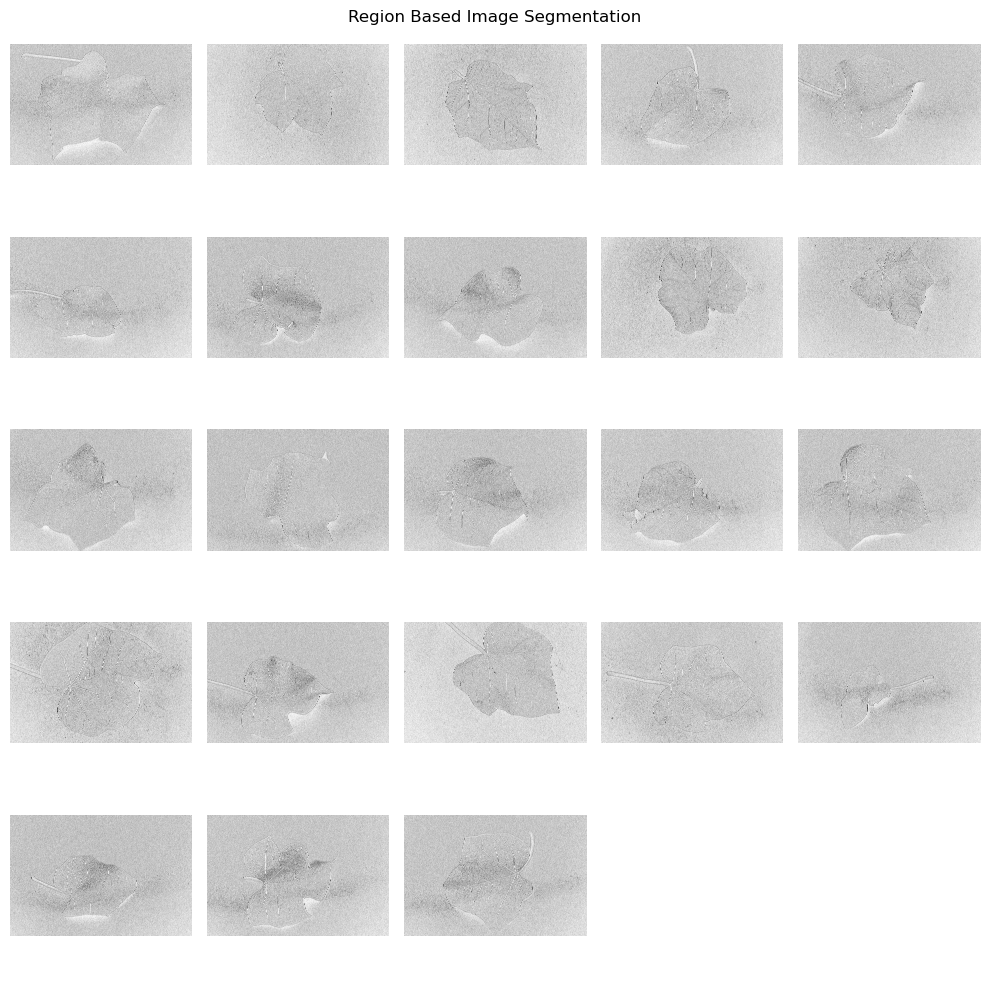

In [4]:
def apply_region_based_segmentation(img):
    thresholded = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    return thresholded

# Assuming you have org_images as a list of input images
# Make sure you have imported org_images before using this code

fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        index = i * 5 + j
        if index < len(org_images):
            gray_img = cv2.cvtColor(org_images[index], cv2.COLOR_BGR2GRAY)
            segmented_img = apply_region_based_segmentation(gray_img)
            axes[i, j].imshow(segmented_img, cmap="gray")
            axes[i, j].axis('off')
        else:
            axes[i, j].axis('off')

plt.tight_layout()
plt.suptitle("Region Based Image Segmentation")
plt.show()

### Q3) Region Growing Segmentation

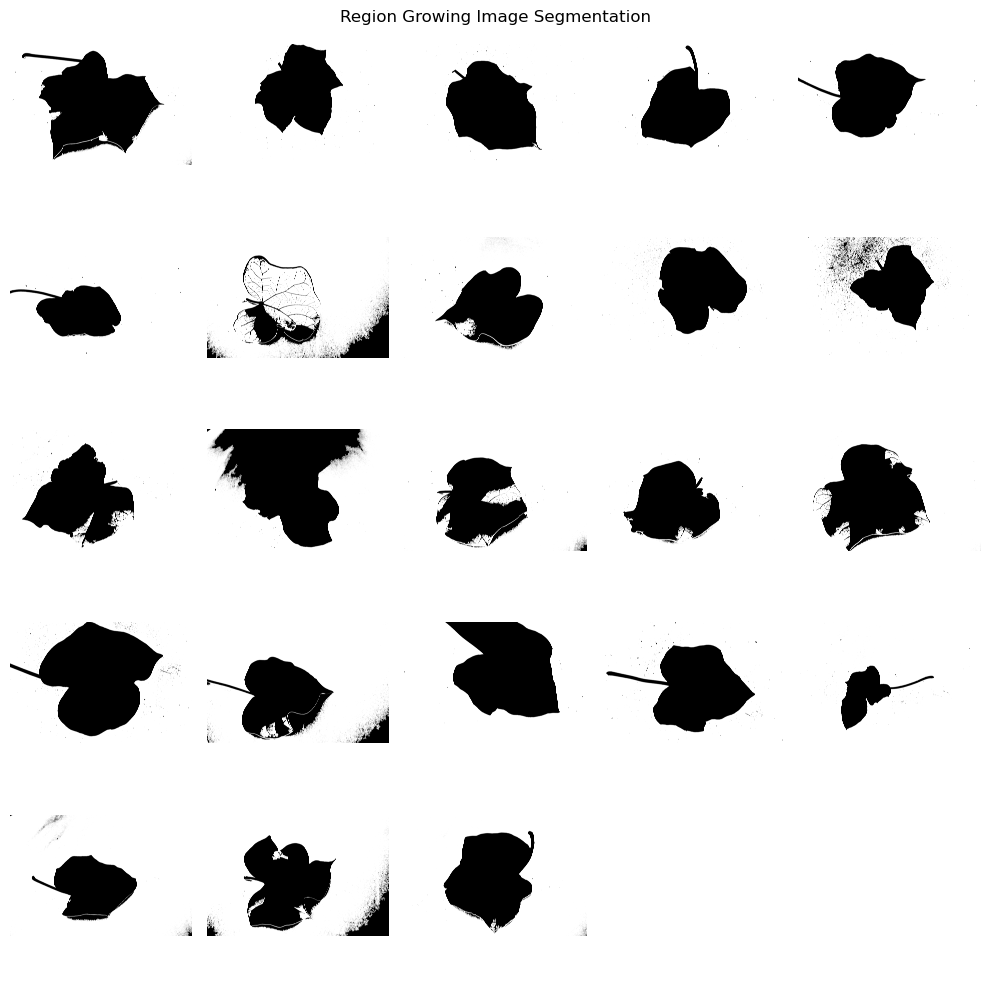

In [5]:
# Define the function for region growing
def perform_region_growing(image, seed_x, seed_y, threshold):
    # Create an output mask with the same dimensions as the image, initialized with zeros
    output_mask = np.zeros_like(image, dtype=np.uint8)

    # Create a stack for iterative region growing
    stack = [(seed_x, seed_y)]

    # Define a function for checking if a point is inside the image boundaries
    def is_inside(x, y):
        return 0 <= x < image.shape[0] and 0 <= y < image.shape[1]

    while stack:
        x, y = stack.pop()
        if not is_inside(x, y) or output_mask[x, y] == 255:
            continue
        if abs(int(image[x, y]) - int(image[seed_x, seed_y])) < threshold:
            output_mask[x, y] = 255
            stack.append((x + 1, y))
            stack.append((x - 1, y))
            stack.append((x, y + 1))
            stack.append((x, y - 1))

    return output_mask

# Assuming you have org_images as a list of input images
# Make sure you have imported org_images, and threshold_value before using this code
seed_x = 100
seed_y = 100
threshold_value = 30

fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        index = i * 5 + j
        if index < len(org_images):
            gray_img = cv2.cvtColor(org_images[index], cv2.COLOR_BGR2GRAY)
            output_mask = perform_region_growing(gray_img, seed_x, seed_y, threshold_value)
            axes[i, j].imshow(output_mask, cmap='gray')
            axes[i, j].axis('off')
        else:
            axes[i, j].axis('off')

plt.tight_layout()
plt.suptitle("Region Growing Image Segmentation")
plt.show()

### Q4) Edge Based Image Segmentation

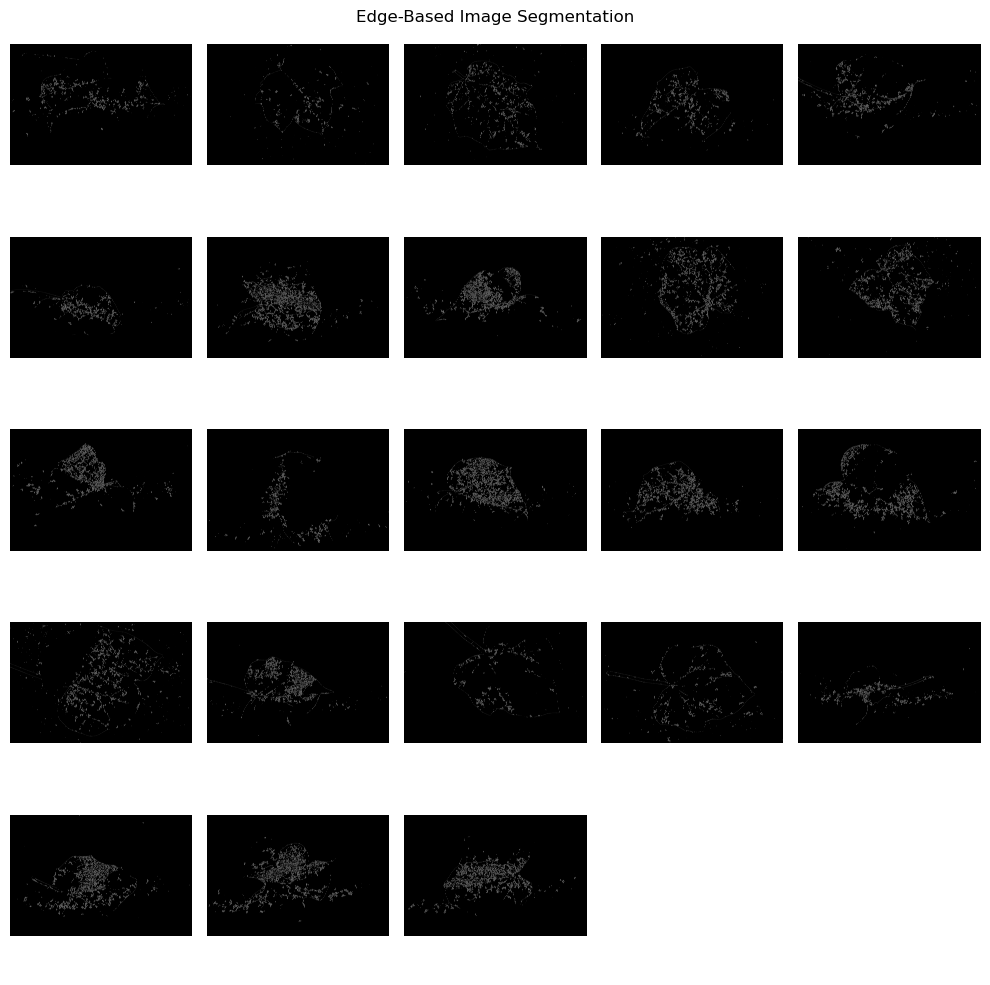

In [6]:
def perform_edge_segmentation(img):
    edges = cv2.Canny(img, threshold1=120, threshold2=10)
    return edges

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        index = i * 5 + j
        if index < len(org_images):
            gray_img = cv2.cvtColor(org_images[index], cv2.COLOR_BGR2GRAY)
            edges = perform_edge_segmentation(gray_img)
            axes[i, j].imshow(edges, cmap="gray")
            axes[i, j].axis('off')
        else:
            axes[i, j].axis('off')

plt.tight_layout()
plt.suptitle("Edge-Based Image Segmentation")
plt.show()

### Q5) Clustering Based Image Segmentation

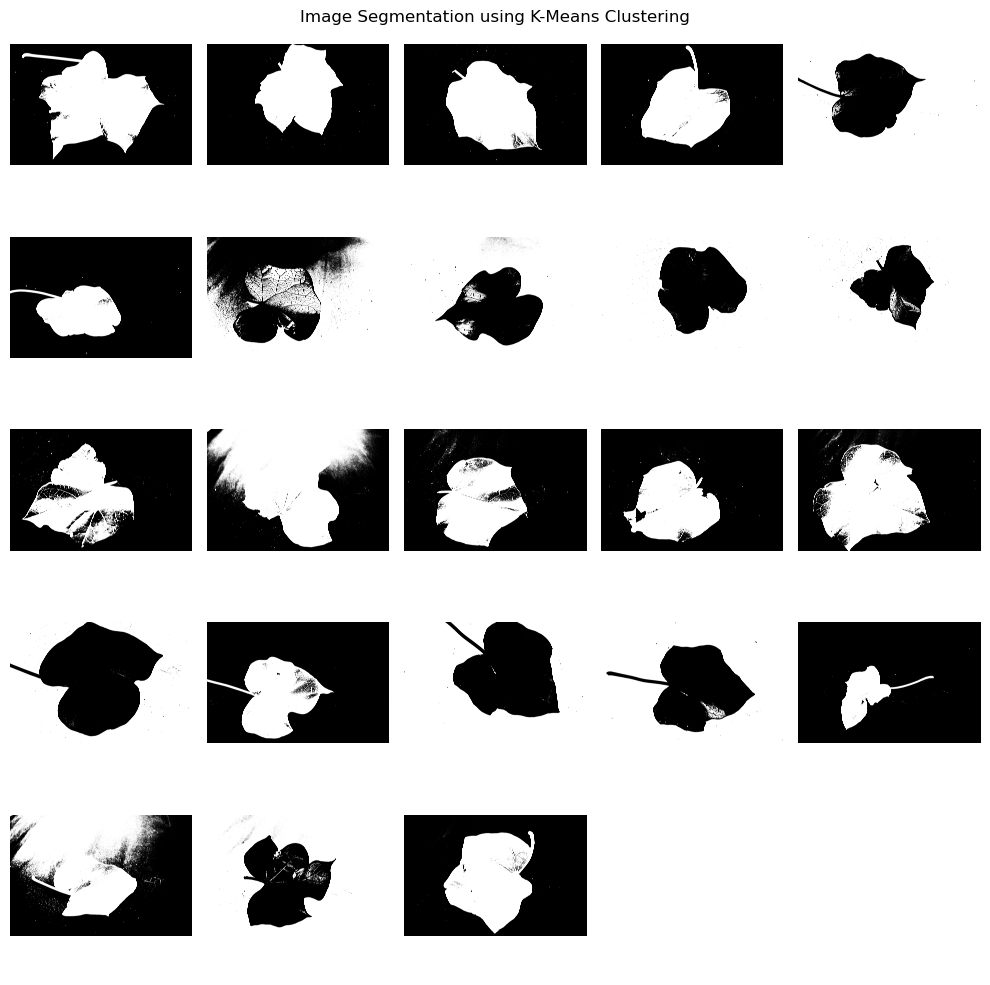

In [7]:
def segment_image_using_kmeans(img):
    pixels = img.reshape((-1, 3))
    kmeans = KMeans(n_clusters=2, n_init=10)
    kmeans.fit(pixels)
    segment_img = kmeans.labels_.reshape(img.shape[:2])
    return segment_img

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        index = i * 5 + j
        if index < len(org_images):
            segment_img = segment_image_using_kmeans(org_images[index])
            axes[i, j].imshow(segment_img, cmap="gray")  # Add cmap="gray" to display as grayscale
            axes[i, j].axis('off')
        else:
            axes[i, j].axis('off')

plt.tight_layout()
plt.suptitle("Image Segmentation using K-Means Clustering")
plt.show()

### Q6) ANN Based Image Segmentation

1/1 [==============================] - 6s 6s/step


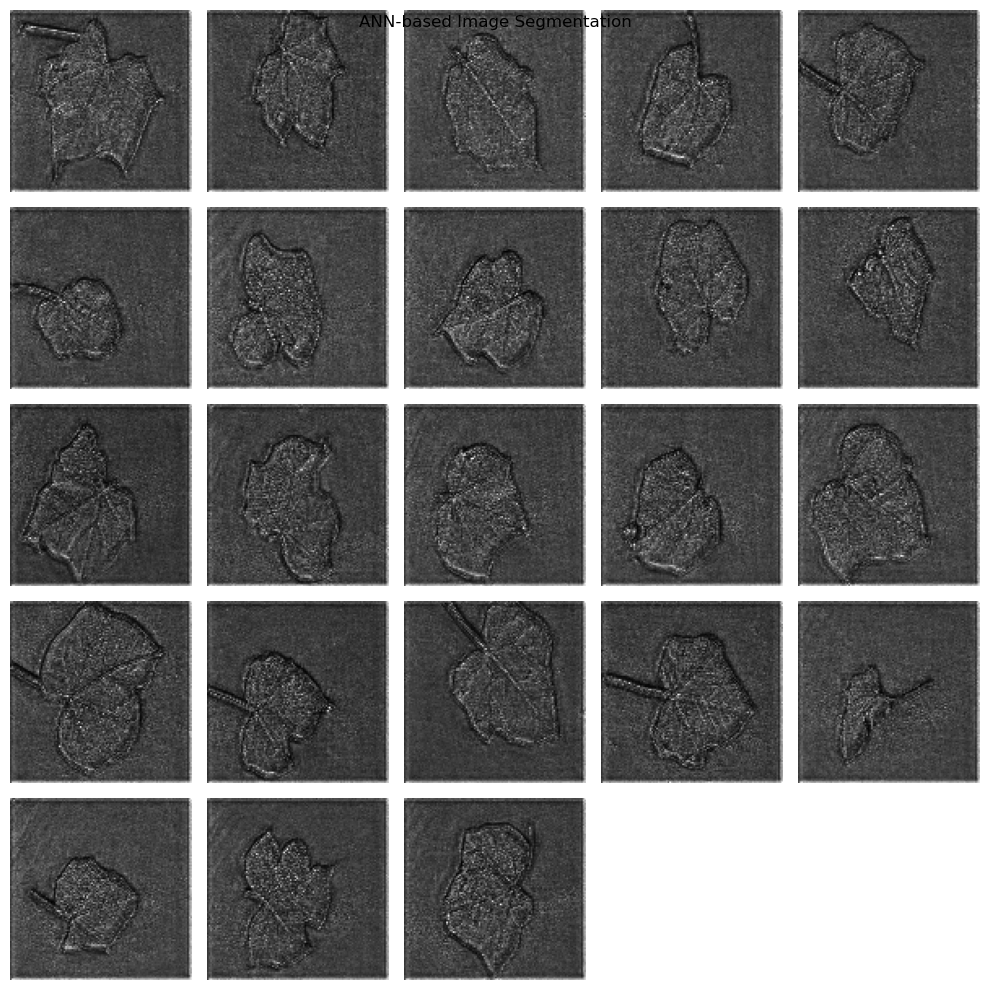

In [8]:
# Load a pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Use intermediate layers for skip connections in U-Net
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

layers = [base_model.get_layer(name).output for name in layer_names]

# Create the decoder part of U-Net
x = layers[-1]
for layer in reversed(layers[:-1]):
    x = UpSampling2D()(x)
    x = Concatenate()([x, layer])
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)

# Output layer for segmentation
num_classes = 2
outputs = Conv2D(num_classes, 1, activation='softmax')(x)

# Create the U-Net model
model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Preprocess images for segmentation
segmentation_images = []
for img in org_images:
    resized_image = cv2.resize(img, (224, 224))
    preprocessed_image = tf.keras.applications.mobilenet_v2.preprocess_input(resized_image)
    segmentation_images.append(preprocessed_image)

segmentation_images = np.array(segmentation_images)
segmentation_masks = model.predict(segmentation_images)

# Visualize the results
plt.figure(figsize=(10, 10))
for i in range(len(org_images)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(segmentation_masks[i][:, :, 1], cmap='gray')  # Assuming class 1 is the object of interest
    plt.axis('off')

plt.tight_layout()
plt.suptitle("ANN-based Image Segmentation")
plt.show()